<a href="https://colab.research.google.com/github/uol-mediaprocessing/group-projects-image-restauration/blob/master/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Group H: Restoration of Damaged Images

Group members:

- Sören Gade
- Florian Meyer

**Definition**: Image restoration is the process of reversing processes that damaged the image. The objective of image restoration techniques is to reduce noise and recover resolution loss.
(see https://en.wikipedia.org/wiki/Image_restoration)

## Goals

The following goals should be accomplished until the end of the project:

1. Independant restoration of damaged images.
   The application should be able to restore images without guidance.
2. Autonomous detection of defects in images.
   The application should detect defects (white damages) that need repairing without guidance.

## Limitations

The following points make the goals more clear:

1. Damages should be clearly visible and discernable from the image's content.
2. Restoration only of images in grayscale or sepia color spaces.

## Scenarios

1. People discovering old photos that have been damaged by a poor storage environment (band marks, white areas).
2. Images that are split in multiple parts and need to be joined together seamlessly. The parts need to be fit together beforehand, letting the programm fill out damages and missing colors.

## Link collection

- https://towardsdatascience.com/how-to-perform-image-restoration-absolutely-dataset-free-d08da1a1e96d
- https://www.owlnet.rice.edu/~elec539/Projects99/BACH/proj2/intro.html
- https://www.slideshare.net/kalyanacharjya/image-restoration-40589017
- https://de.wikipedia.org/wiki/Inpainting
- http://www-inst.eecs.berkeley.edu/~ee225b/sp07/handouts/Image_Restoration_99.pdf
- https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_photo/py_inpainting/py_inpainting.html
- Digital Restoration from Start to Finish: How to repair old and damaged photographs, ISBN 9781136098130


# Setup

The following setup functions are needed for the execution of all related functionality.

In [0]:
import matplotlib
%matplotlib inline
import cv2
import matplotlib.pyplot as plt

In [0]:
! wget -q https://raw.githubusercontent.com/uol-mediaprocessing/group-projects-image-restauration/master/src/sample01-damaged.jpg
! wget -q https://raw.githubusercontent.com/uol-mediaprocessing/group-projects-image-restauration/master/src/sample01-mask.jpg
! wget -q https://raw.githubusercontent.com/uol-mediaprocessing/group-projects-image-restauration/master/src/sample02-damaged.jpg
! wget -q https://raw.githubusercontent.com/uol-mediaprocessing/group-projects-image-restauration/master/src/sample02-mask.jpg
! wget -q https://raw.githubusercontent.com/uol-mediaprocessing/group-projects-image-restauration/master/src/sample03-damaged.jpg
! wget -q https://raw.githubusercontent.com/uol-mediaprocessing/group-projects-image-restauration/master/src/sample03-mask.jpg
! wget -q https://raw.githubusercontent.com/uol-mediaprocessing/group-projects-image-restauration/master/src/sample04.jpg
! wget -q https://raw.githubusercontent.com/uol-mediaprocessing/group-projects-image-restauration/master/src/example01-damaged.png
! wget -q https://raw.githubusercontent.com/uol-mediaprocessing/group-projects-image-restauration/master/src/example02.jpg

# Restoration process

Algorithm: Inpainting (https://en.wikipedia.org/wiki/Inpainting)

* Goals
  * Restore damaged or missing parts of an image.
  * Remove undesired objects.
  * Image compression by deleting similar blocks of images
* Process
  * Restore an image that is based on the entire look of the damaged image.
  * Structures are continued along their path.
  * Masks define areas that are filled based on the colors at their borders.

Different algorithms, OpenCV offers two:
  * Telea (A Telea, An image inpainting technique based on the fast marching method , J. GRAPHICS TOOLS, 2004.)
    * Based on Fast Marching Method, thereby works more like a manual heuristic operation
    * Starts at boundary and works into the region gradually
    * Pixel values are determined by a weighted sum of all the known pixels in the neighbourhood (selection of weight is therefore important)
    * Weights are higher near the pixel, at the normal of the boundary and on boundary contours
  * Navier-Stokes based (M. Bertalmio, A. L. Bertozzi, G. Sapiro, Navier-Stokes, Fluid Dynamics, and Image and Video Inpainting, IEEE CVPR, 2001.)
    * Based on heuristics and fluid dynamics
    * First works along edges from known to unknown regions
    * Uses partial differential equations
    * Reduces minimum variance in color

https://docs.opencv.org/3.4/df/d3d/tutorial_py_inpainting.html

# Restoring images using predefined masks

In the following three samples the fundamental action of restoring images is displayed.

First a damaged image is needed. After that a mask of the damages in the image are needed. The mask shows the damaged areas so that the `inpaint` method in PpenCV can restore the image.

In [0]:
def imread_mask(name):
  """Reads an RGB image and returns only one channel.
  Such a single channel is needed for a mask.
  """
  mask = cv2.imread(name)
  return mask[:, :, 0] # mask needs to be one channel only

## Sample 01
The damaged image

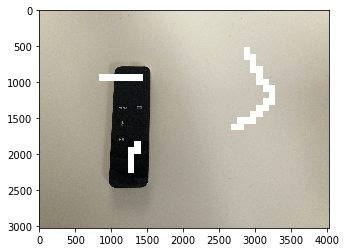

In [0]:
sample1 = cv2.imread("sample01-damaged.jpg")

plt.imshow(cv2.cvtColor(sample1, cv2.COLOR_BGR2RGB))

The mask of the first damaged image

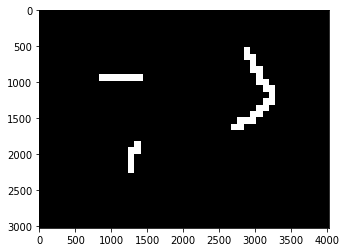

In [0]:
mask1 = imread_mask("sample01-mask.jpg")

plt.imshow(mask1, cmap='gray')

The restored image


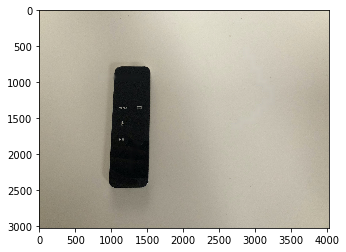

In [0]:
sample1 = cv2.imread("sample01-damaged.jpg")
mask1 = imread_mask("sample01-mask.jpg")

radius = 15
result1 = cv2.inpaint(sample1, mask1, radius, cv2.INPAINT_TELEA)

plt.imshow(cv2.cvtColor(result1, cv2.COLOR_BGR2RGB))

## Sample 02

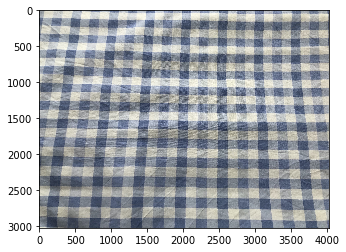

In [0]:
sample2 = cv2.imread("sample02-damaged.jpg")
mask2 = imread_mask("sample02-mask.jpg")

radius = 10
result2 = cv2.inpaint(sample2, mask2, radius, cv2.INPAINT_TELEA)

plt.imshow(cv2.cvtColor(result2, cv2.COLOR_BGR2RGB))

## Sample 03

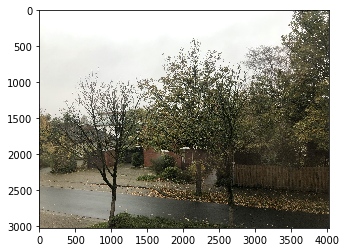

In [0]:
mask3 = imread_mask("sample03-mask.jpg")

radius = 10
result3 = cv2.inpaint(sample3, mask3, radius, cv2.INPAINT_TELEA)

plt.imshow(cv2.cvtColor(result3, cv2.COLOR_BGR2RGB))

## Observations from Samples 01-03

1. Using the `inpaint` method, only small damages can be repaired in a meaningful way. The method uses colors around the damage to restore the image's colors.
2. Small damages in high resolution images become nearly invisible when looking at the entire image.
3. `inpaint` seems to be a good choice when restoring pixels in images based on their neighbours.

# Build a mask automatically

To restore images automatically, the mask needs to be created by the application itself.
Our first idea consists of the following steps:

1. Convert the input image to grayscale.
2. Use the `threshold` method to find parts that are above a fixed intensity value.

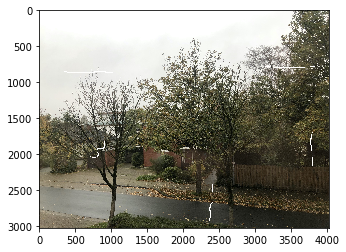

In [0]:
sample3 = cv2.imread("sample03-damaged.jpg")

plt.imshow(cv2.cvtColor(sample3, cv2.COLOR_BGR2RGB))

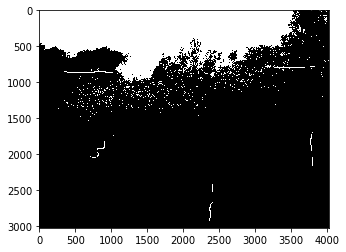

In [0]:
def create_mask(src):
  # convert image to grayscale
  mask = cv2.cvtColor(src, cv2.COLOR_BGR2GRAY)
  # only use values above a given threshold
  (_, mask) = cv2.threshold(mask, 240, 255, cv2.THRESH_BINARY)
  return mask

img = cv2.imread("sample03-damaged.jpg")
mask = create_mask(img)

plt.imshow(mask, cmap='gray')

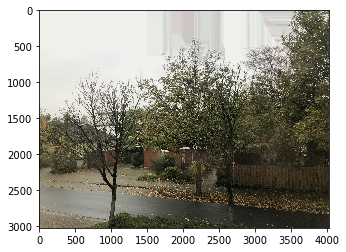

In [0]:
def restore_image(src, mask, radius=10):
  return cv2.inpaint(src, mask, radius, cv2.INPAINT_NS)

result = restore_image(img, mask)
plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))

## Observations

1. Detection of damages using color values thresholds is a simple and yet effective method. Further research might produce a better method for mask creation.
2. As damages are defined as "white", bright section of images are often included in the mask. This restores healthy parts of such images and also prolongues the duration of the inpainting method.
3. The detected damaged areas cannot be resolved by the `inpaint` method

# Build a mask automatically: Blur

In part, thresholding finds very specific points in the damages.
Blurring the areas around the damaged areas could help the algorithm to restore the image (https://www.tutorialkart.com/opencv/python/opencv-python-gaussian-image-smoothing/) around the edges of the damages.

This smoothes out the damages with the areas around it.

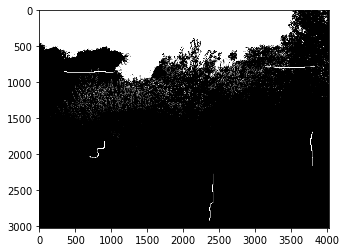

In [0]:
def create_mask(src):
  # convert image to grayscale
  mask = cv2.cvtColor(src, cv2.COLOR_BGR2GRAY)
  # only use values above a given threshold
  (_, mask) = cv2.threshold(mask, 240, 255, cv2.THRESH_BINARY)
  # blur the mask
  mask = cv2.GaussianBlur(mask, (5, 5), 10)
  return mask

img = cv2.imread("sample03-damaged.jpg")
mask = create_mask(img)

plt.imshow(mask, cmap='gray')

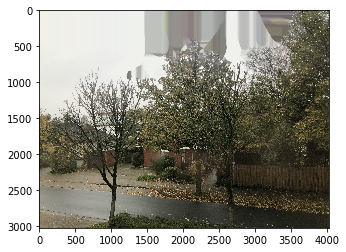

In [0]:
result = restore_image(img, mask)
plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))

## Observations

* Different result in Colab than seen on local machine.
* Locally better results of damaged images.

# Build a mask automatically: Adaptive Thresholding

Using fixes values in the thresholding algorithm does not take into account that the images are not always dark with white damages. Sometimes, the damages are colored similar to the background parts of the image contents.

Using adaptive thresholding, the threshold values are determined by the area around the pixel in question. Therefore, sharp edges that might be caused by damages are more apparent.

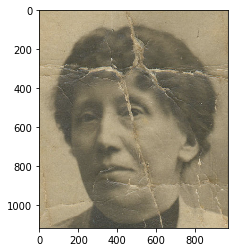

In [0]:
img = cv2.imread("example01-damaged.png")
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

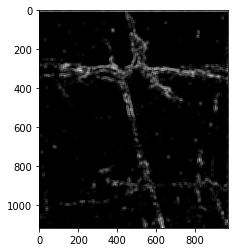

In [0]:
def create_mask(src):
  # convert image to grayscale
  mask = cv2.cvtColor(src, cv2.COLOR_BGR2GRAY)
  # only use values above a given threshold
  mask = cv2.adaptiveThreshold(mask, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 9, 10)
  # blur the mask
  mask = cv2.GaussianBlur(mask, (15, 15), 20)
  return mask

img = cv2.imread("example01-damaged.png")
mask = create_mask(img)

plt.imshow(mask, cmap='gray')

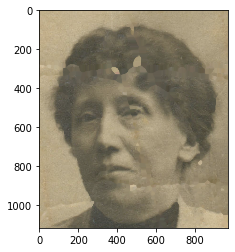

In [0]:
def restore_image(src, mask, radius=10):
  return cv2.inpaint(src, mask, radius, cv2.INPAINT_TELEA)

result = restore_image(img, mask)
plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))

# Build a mask automatically: Equalize Histogram

Spread out the histogram to make the damages more apparent.

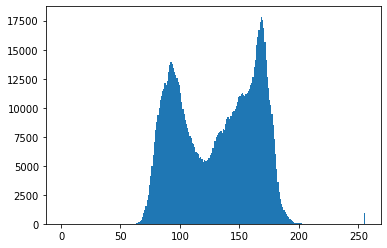

In [0]:
#hist = cv2.calcHist([img], [0], None, [256], [0, 256])

img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.hist(img_gray.ravel(), 256, [0, 256])
plt.show()

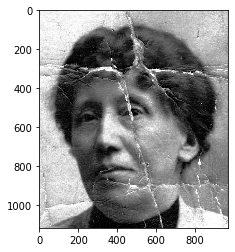

In [0]:
img_equalized = cv2.equalizeHist(img_gray)
plt.imshow(img_equalized, cmap='gray')

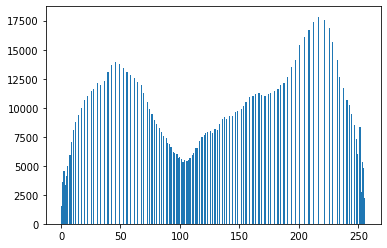

In [0]:
plt.hist(img_equalized.ravel(), 256, [0, 256])
plt.show()

## Remove salt

Spreading out histogram increases the noise in the image. To remove the salt in the mask, we use median blur.

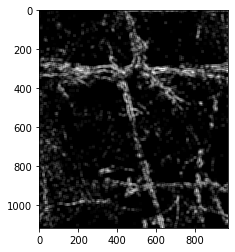

In [0]:
def create_mask(src):
  # only use values above a given threshold
  mask = cv2.adaptiveThreshold(src, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 9, 10)
  # remove salt
  mask = cv2.medianBlur(mask, 5)
  # blur the mask
  mask = cv2.GaussianBlur(mask, (15, 15), 20)
  return mask

mask = create_mask(img_equalized)

plt.imshow(mask, cmap='gray')

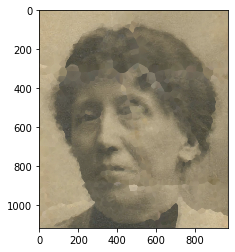

In [0]:
def restore_image(src, mask, radius=3):
  return cv2.inpaint(src, mask, radius, cv2.INPAINT_TELEA)

result = restore_image(img, mask)
plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))

## Experiments with different images

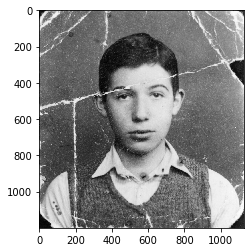

In [0]:
img = cv2.cvtColor(cv2.imread('sample04.jpg'), cv2.COLOR_BGR2GRAY)
plt.imshow(img, cmap='gray')

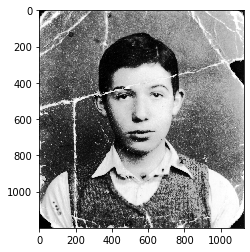

In [0]:
img = cv2.equalizeHist(img)
plt.imshow(img, cmap='gray')

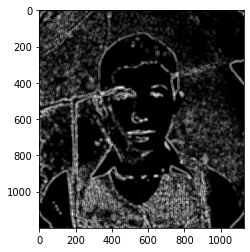

In [0]:
mask = create_mask(img)
plt.imshow(mask, cmap='gray')

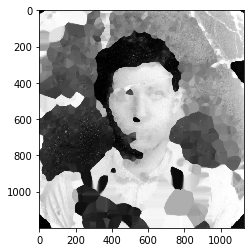

In [0]:
result = restore_image(img, mask)
plt.imshow(result, cmap='gray')

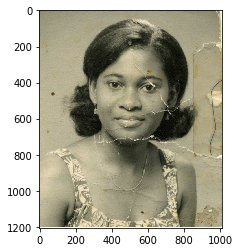

In [0]:
img = cv2.imread('example02.jpg')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

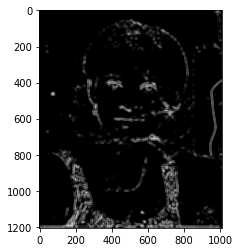

In [0]:
mask = create_mask(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY))
plt.imshow(mask, cmap='gray')

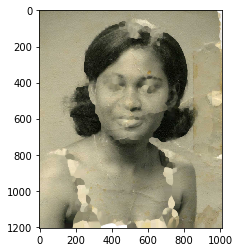

In [0]:
result = restore_image(img, mask)
plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))

## Observations

1. Using adaptive thresholding to find the edges of the damages is succesful.
2. Using blur to smooth out the mask makes the restored image look better.
3. Using histogram equalization actually decreases the effects in the restored image.

### Next steps

- Finding faces in masks and reducing mask intensity there using erosion.

# On Using Deep Learning

* Restoration using classic methods is limited
* Using deep learning can provide results often surpassing human accuracy (https://heartbeat.fritz.ai/guide-to-image-inpainting-using-machine-learning-to-edit-and-correct-defects-in-photos-3c1b0e13bbd0)
* Generative adversarial networks can generate the missing data

Problems:

* Requires big data sets and training
* Does not provide much better results according to others

In [0]:
! wget -q https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalface_alt.xml

Found 1 face(s).


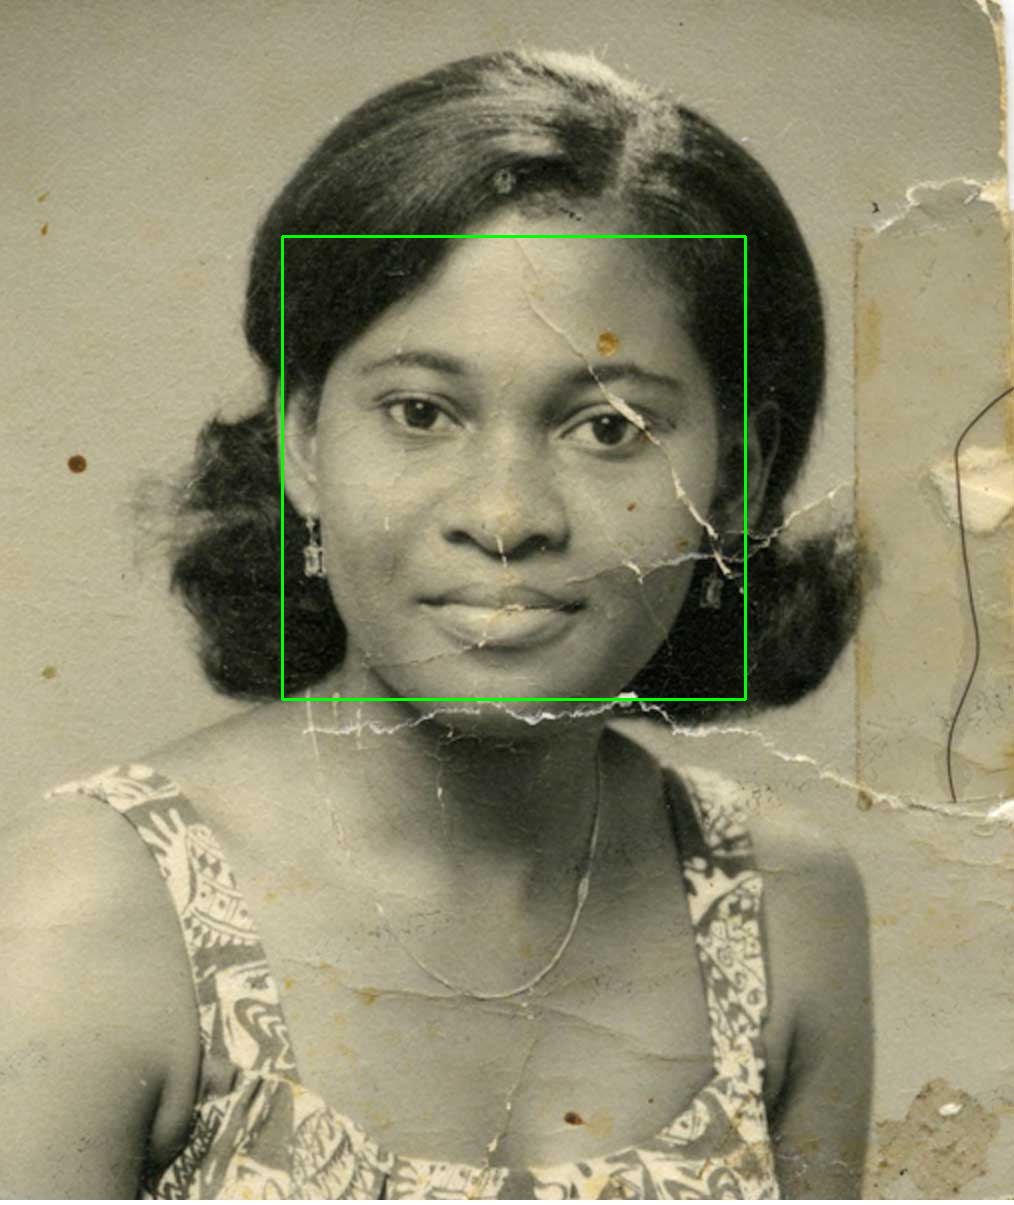

In [12]:
from google.colab.patches import cv2_imshow

img = cv2.imread('example02.jpg')
imgGray = cv2.cvtColor(img.copy(), cv2.COLOR_BGR2GRAY)

#plt.imshow(imgGray, cmap='gray')

faceClassifier = cv2.CascadeClassifier('haarcascade_frontalface_alt.xml')
faces = faceClassifier.detectMultiScale(imgGray, scaleFactor=1.1, minNeighbors=5)

print('Found ' + str(len(faces)) + ' face(s).')

for (x, y, w, h) in faces:
  cv2.rectangle(img, (x, y), (x+w, y+h), (0, 255, 0), 2)

cv2_imshow(img)
#plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))